In [1]:
%cd ../..

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("seaborn")

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA as tsa_ARIMA

from tseries.utils.general import LogTime
from tseries.utils.ts_utils import forecast_bias
from tseries.forecasting.baselines import NaiveMovingAverage
from tseries.transforms.stationary_utils import check_unit_root, check_trend, check_deterministic_trend, check_seasonality, check_heteroscedastisticity
from tseries.transforms.target_transformations import AutoStationaryTransformer, BoxCoxTransformer

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.templates.default = "plotly_white"

from darts.models import NaiveSeasonal, ExponentialSmoothing, FourTheta as Theta, ARIMA, AutoARIMA, FFT
from darts import TimeSeries
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode
from darts.metrics import mase, mse, mae
from darts.metrics.metrics import _get_values_or_raise
from darts.metrics import metrics as dart_metrics

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting\tseries\utils\data_utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Dataset

In [3]:
data = pd.read_csv('data/harga-emas-antam-cleaned.csv', 
                     index_col='Date', 
                     parse_dates=True)
data.columns = ['y']
data.index.freq = 'D'
data

,y
Date,
2010-01-04,408000.0
2010-01-05,410000.0
2010-01-06,410000.0
2010-01-07,412000.0
2010-01-08,410000.0
...,...
2024-04-26,1319000.0
2024-04-27,1326000.0
2024-04-28,1326000.0


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
y,5231.0,705158.459186,207328.180877,394000.0,564000.0,617000.0,930000.0,1347000.0


In [5]:
data.isnull().sum()

y    0
dtype: int64

c:\Users\Fahmi Maulana\Documents\Projects\antam-forecasting\tseries\transforms\target_transformations.py:545: UserWarning: Trends with degree>1 are very strong and use with care.
  warnings.warn("Trends with degree>1 are very strong and use with care.")


Transformations applied: ['DetrendingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


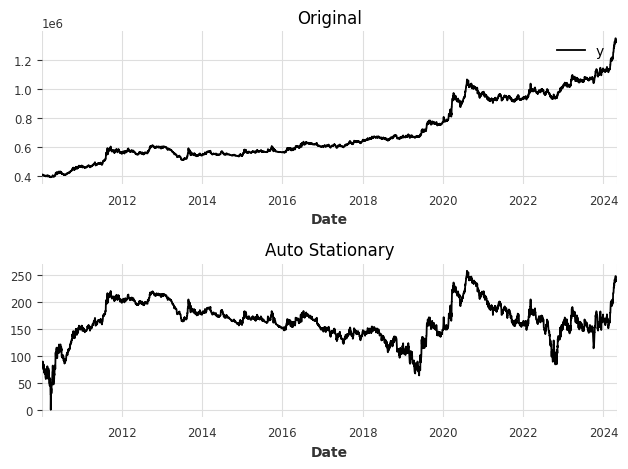

Unit Root: True with a p-value of 0.052096471069093514
Inverse == Original @ precision of 2 decimal points: True


In [6]:
# Now proceed with the rest of your code
auto_stationary = AutoStationaryTransformer(confidence=0.1,
                                            seasonal_period=90,
                                            seasonality_max_lags=365,
                                            detrender_params={'degree':2}, 
                                            deseasonalizer_params = {
                                                "seasonality_extraction": "period_averages",
                                            },
                                            trend_check_params={"mann_kendall":True},
                                            box_cox_params={ "optimization": "guerrero" })
y_stat = auto_stationary.fit_transform(data,freq='D')
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)

data.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()

unit_root = check_unit_root(y_stat, confidence=0.1)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = pd.DataFrame(auto_stationary.inverse_transform(y_stat), index=data.index, columns=["y"])
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(3)==data.round(3))}")

# Splitting Data

In [7]:
# def split_data(data, train_split, val_split, test_split):
#     l = len(data)
#     train_idx = round(l * train_split)
#     val_idx = round(l * (train_split + val_split))
    
#     train, val, test = data[:train_idx], data[train_idx:val_idx], data[val_idx:]
    
#     print(f'train: {len(train)}, val: {len(val)}, test: {len(test)}')
    
#     return train, val, test

In [8]:
# train_data, val_data, test_data = split_data(data, 0.8, 0.1, 0.1)

In [9]:
# pred_df = pd.concat([train_data, val_data])
# metric_record = []

# ts_train = TimeSeries.from_dataframe(train_data)
# ts_val = TimeSeries.from_dataframe(val_data)
# ts_test = TimeSeries.from_dataframe(test_data)

In [10]:
metric_record = []
pred_df = data.copy()
series = TimeSeries.from_dataframe(data)
ts_train, ts_val = series.split_after(pd.Timestamp('20221231'))

# Helper Functions

In [11]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        # "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

In [12]:
def plot_forecast_mb(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = plt.cm.Dark2(np.linspace(0, 1, len(forecast_columns)))
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot actual consumption
    ax.plot(pred_df[mask].index, pred_df[mask].y, label='Actual Consumption', color='grey', alpha=0.8)
    
    # Plot forecasted values
    for col, display_col, color in zip(forecast_columns, forecast_display_names, colors):
        ax.plot(pred_df[mask].index, pred_df.loc[mask, col], label=display_col, linestyle='--', color='red')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    plt.grid(True)
    plt.title('Forecasted Values vs. Actual Consumption')
    plt.show()

In [13]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [14]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
#     change y to your time series column
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].y,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

# Statistical Models
## Naive Model

In [15]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [16]:
fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2010-01-01", "2024-04-30"])
# fig.write_image("antam-forecast/images/naive.png")
fig.show()

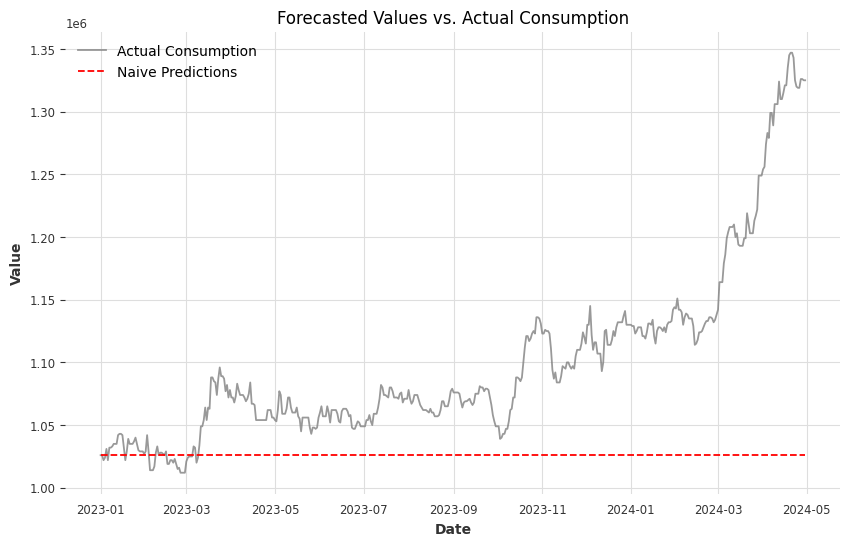

In [17]:
plot_forecast_mb(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])

## Moving Average

In [18]:
name = "Moving Average Forecast"
ma_model = NaiveMovingAverage(window=7)
with LogTime() as timer:
    y_pred, metrics = eval_model(ma_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [19]:
fig = plot_forecast(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['Moving Average Predictions'])
fig = format_plot(fig, title=f"Moving Average: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/moving_average.png")
fig.show()

## Seasonal Naive

In [20]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=14)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "snaive_predictionss")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [21]:
fig = plot_forecast(pred_df, forecast_columns=["snaive_predictionss"], forecast_display_names=['Seasonal Naive Predictions'])
fig = format_plot(fig, title=f"Seasonal Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/seasonal_naive.png")
fig.show()

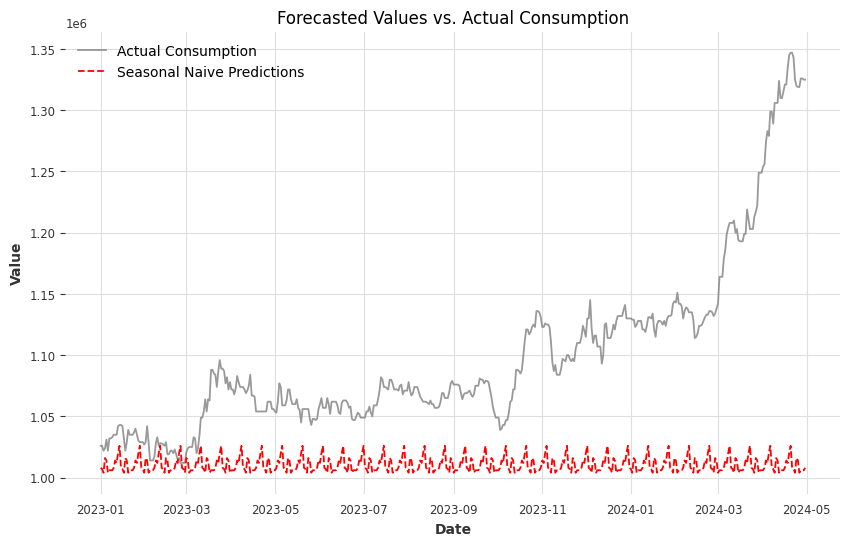

In [22]:
plot_forecast_mb(pred_df, forecast_columns=["snaive_predictionss"], forecast_display_names=['Seasonal Naive Predictions'])

## Exponential Smoothing

In [23]:
import warnings

In [24]:
name = "Exponential Smoothing"
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, damped=True, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=14, random_state=42)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train, ts_val, name=name)
    metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pred_df.join(y_pred)

c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul



Time Elapsed: 4 seconds


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\ml_engineering\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [25]:
fig = plot_forecast(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])
fig = format_plot(fig, title=f"Exponential Smoothing: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/ets.png")
fig.show()

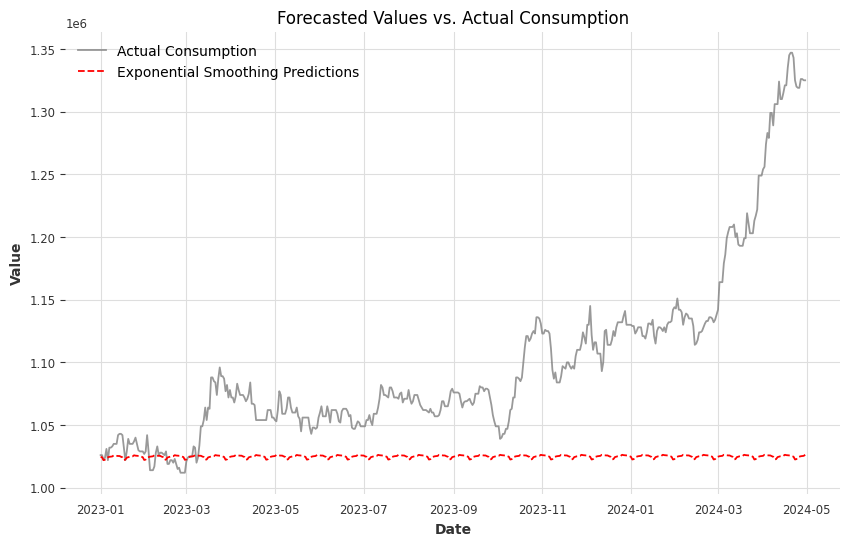

In [26]:
plot_forecast_mb(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])

## Theta

In [27]:
name = "Theta"
theta_model = Theta(theta=5, seasonality_period=180, season_mode=SeasonalityMode.ADDITIVE, trend_mode=TrendMode.EXPONENTIAL)
with LogTime() as timer:
    y_pred, metrics = eval_model(theta_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [28]:
fig = plot_forecast(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])
fig = format_plot(fig, title=f"Theta: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/theta.png")
fig.show()

## FFT

In [29]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=30, trend="poly", trend_poly_degree=3)
with LogTime() as timer:
    y_pred, metrics = eval_model(fft_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [30]:
fig = plot_forecast(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])
fig = format_plot(fig, title=f"FFT: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/fft.png")
fig.show()

## ARIMA

In [31]:
name = "ARIMA"
arima_model = ARIMA(p=1, d=1, q=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train, ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "arima_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [32]:
fig = plot_forecast(pred_df, forecast_columns=["arima_predictions"], forecast_display_names=['ARIMA Predictions'])
fig = format_plot(fig, title=f"ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/arima.png")
fig.show()

## SARIMA

In [33]:
name = "SARIMA"
arima_model = ARIMA(p=1, d=1, q=1, seasonal_order=(1,1,1,30))
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train, ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "sarima_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 minute and 1 second


In [34]:
fig = plot_forecast(pred_df, forecast_columns=["sarima_predictions"], forecast_display_names=['SARIMA Predictions'])
fig = format_plot(fig, title=f"SARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# fig.write_image("energy-consumption/images/arima.png")
fig.show()

## Seasonal Decomposition Forecast

In [35]:

def seasonal_decompose_forecast(ts_train, ts_test, residual_model_order=(1, 0, 1)):
    # Convert TimeSeries to pandas Series
    ts_train_series = ts_train.pd_series()
    ts_test_series = ts_test.pd_series()
    stlf = STLForecast(ts_train_series, tsa_ARIMA, model_kwargs=dict(order=residual_model_order, trend="t"))
    stlf_res = stlf.fit()

    forecast = stlf_res.forecast(len(ts_test_series))
    y_pred = TimeSeries.from_series(forecast)
    return y_pred

# Define eval_model function for seasonal decomposition forecasting
def eval_decompose_model(ts_train, ts_test, name=None, residual_model_order=(1, 0, 1)):
    if name is None:
        name = 'Seasonal_Decompose_Forecast'
    y_pred = seasonal_decompose_forecast(ts_train, ts_test, residual_model_order)
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
    }

In [36]:
name = "STL ARIMA"
with LogTime() as timer:
    y_pred, metrics = eval_decompose_model(ts_train, ts_val, name=name, residual_model_order=(1, 0, 1))
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "decomposition_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 second


In [37]:
fig = plot_forecast(pred_df, forecast_columns=["decomposition_predictions"], forecast_display_names=['Decomposition Predictions'])
fig = format_plot(fig, title=f"SD with ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

# Evaluation Model Results

In [38]:
baseline_metrics_df = (pd.DataFrame(metric_record)).sort_values("MAE", ascending=True)
baseline_metrics_df

,Algorithm,MAE,MSE,MASE,Time Elapsed
7,SARIMA,29595.768722,2.559843e+09,12.724518,61.712688
8,STL ARIMA,42518.379426,4.621975e+09,18.280514,1.839511
4,Theta,46341.751037,5.261116e+09,19.924349,0.032700
5,FFT,57599.455840,4.405149e+09,24.764530,0.032969
0,Naive,74034.979424,1.043405e+10,31.830881,0.008730
6,ARIMA,74230.855936,1.046655e+10,31.915097,0.461885
3,Exponential Smoothing,74958.210429,1.058260e+10,32.227819,4.770505
1,Moving Average Forecast,82938.565986,1.192804e+10,35.658923,0.011050
2,Seasonal Naive Forecast,88592.592593,1.294447e+10,38.089837,0.007507
